In [0]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

import torch
from torchvision import datasets,transforms
from torch import nn
import torch.nn.functional as F
from torch.utils.data.sampler import SubsetRandomSampler

In [7]:
transform = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize((0.5,0.5,0.5),
                                                    (0.5,0.5,0.5))])

wholeTrainset=datasets.CIFAR10(root='../data/CIFAR10',download=True,
                              train=True,transform=transform)
testdataset=datasets.CIFAR10('../data/CIFAR10',download=True,
                            train=False,transform=transform)
valid_p = 0.2
indices=list(range(len(wholeTrainset)))
np.random.shuffle(indices)
per_index=int(np.floor(valid_p*len(indices)))
valid_indices,train_indices=indices[:per_index],indices[per_index:]

trainsampler=SubsetRandomSampler(indices=valid_indices)
validsampler=SubsetRandomSampler(indices=train_indices)

trainloader=torch.utils.data.DataLoader(wholeTrainset,batch_size=32,
                                        sampler=trainsampler)
validloader=torch.utils.data.DataLoader(wholeTrainset,batch_size=32,
                                        sampler=validsampler)
testloader=torch.utils.data.DataLoader(testdataset,batch_size=32)

Files already downloaded and verified


In [0]:
classes=['airplane','automobile','bird','cat','deer','dog',
        'frog','horse','ship','truck']
def imshow(img):
    img=img*0.5+0.5;
    plt.imshow(np.transpose(img,(1,2,0)))

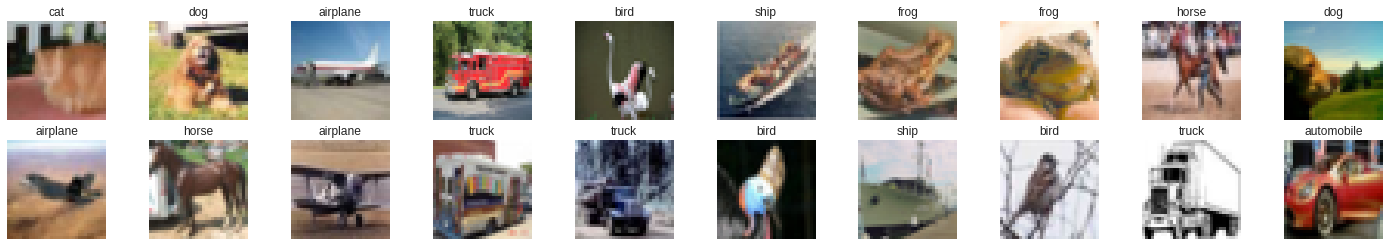

In [9]:
images,labels=next(iter(trainloader))
images=images.numpy()

fig=plt.figure(figsize=(25,4))
for idx in range(20):
    ax=fig.add_subplot(2,20/2,idx+1,xticks=[],yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

In [10]:
images[0].shape

(3, 32, 32)

In [0]:
class Network(nn.Module):
    
    def __init__(self):
        super().__init__();
        
        self.conv2d1=nn.Conv2d(3,32,3,padding=1)
        self.maxpool=nn.MaxPool2d(2,2)
        self.conv2d2=nn.Conv2d(32,32,3,padding=1)
        self.conv2d3=nn.Conv2d(32,64,3,padding=1)
        self.conv2d4=nn.Conv2d(64,64,3,padding=1)
        self.dropout=nn.Dropout(p=0.25)
        
        self.flatten=nn.Linear(64*8*8,512)
        self.output=nn.Linear(512,10)
    
    def forward(self,x):
        x=F.relu(self.conv2d1(x))
        x=F.relu(self.conv2d2(x))
        x=self.maxpool(x)
        x=self.dropout(x)
        
        x=F.relu(self.conv2d3(x))
        x=F.relu(self.conv2d4(x))
        x=self.maxpool(x)
        x=self.dropout(x)
        
        in_batchsize=x.shape[0]
        x=self.flatten(x.view(in_batchsize,-1))
        x=F.relu(x)
        x=self.dropout(x)
        x=self.output(x)
        x=F.log_softmax(x,dim=1)
        
        return x

In [12]:
model=Network()
print(model)

Network(
  (conv2d1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2d2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2d3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2d4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dropout): Dropout(p=0.25)
  (flatten): Linear(in_features=4096, out_features=512, bias=True)
  (output): Linear(in_features=512, out_features=10, bias=True)
)


In [0]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters())

In [0]:
model.to(device);
def train(Model,trainloader,testloader,criterion,optimizer,epochs=5):
    test_losses,train_losses=[],[]
    for e in range(epochs):
        running_loss=0;

        Model.train();
        for images,labels in trainloader:
#             images_t = images.view(images.shape[0],-1);
            optimizer.zero_grad();
            images,labels=images.to(device),labels.to(device)
            
            logits=Model.forward(images);
            loss_t=criterion(logits,labels);
            loss_t.backward();
            optimizer.step();

            running_loss+=loss_t;

        else:
            test_loss,accuracy=validation(Model,testloader,criterion);

            print("Epoch: {}/{}.. ".format(e+1, epochs),
                      "Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)),
                      "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
                      "Test Accuracy: {:.3f}".format(accuracy))

        test_losses.append(test_loss/len(testloader))
        train_losses.append(running_loss/len(trainloader))

    return train_losses,test_losses,accuracy

def validation(Model,testloader,criterion):
    test_loss=0;
    accuracy=0;

    Model.eval();
    images_num=0;
    with torch.no_grad():
        for images,labels in testloader:
            images_num+=images.shape[0];
#             images_t=images.view(images.shape[0],-1);
            images,labels=images.to(device),labels.to(device)
            logits=Model.forward(images);
            loss_t=criterion(logits,labels)
            test_loss+=loss_t;

            _,pred_labels=torch.topk(logits,1,dim=1)
            equality=(labels==pred_labels.view(*labels.shape))

            accuracy += torch.sum(equality)

    overall_acc=accuracy.float()/images_num;
    return test_loss,overall_acc


In [16]:
train_loss,test_loss,accuracy=train(model,trainloader,validloader,criterion,
                                   optimizer,20)

Epoch: 1/20..  Training Loss: 1.813..  Test Loss: 1.532..  Test Accuracy: 0.434
Epoch: 2/20..  Training Loss: 1.435..  Test Loss: 1.308..  Test Accuracy: 0.521
Epoch: 3/20..  Training Loss: 1.247..  Test Loss: 1.204..  Test Accuracy: 0.567
Epoch: 4/20..  Training Loss: 1.100..  Test Loss: 1.124..  Test Accuracy: 0.598
Epoch: 5/20..  Training Loss: 0.968..  Test Loss: 1.099..  Test Accuracy: 0.616
Epoch: 6/20..  Training Loss: 0.859..  Test Loss: 1.119..  Test Accuracy: 0.611
Epoch: 7/20..  Training Loss: 0.746..  Test Loss: 1.093..  Test Accuracy: 0.629
Epoch: 8/20..  Training Loss: 0.632..  Test Loss: 1.097..  Test Accuracy: 0.645
Epoch: 9/20..  Training Loss: 0.557..  Test Loss: 1.164..  Test Accuracy: 0.649
Epoch: 10/20..  Training Loss: 0.473..  Test Loss: 1.134..  Test Accuracy: 0.643
Epoch: 11/20..  Training Loss: 0.403..  Test Loss: 1.188..  Test Accuracy: 0.657
Epoch: 12/20..  Training Loss: 0.341..  Test Loss: 1.270..  Test Accuracy: 0.641
Epoch: 13/20..  Training Loss: 0.310.

In [34]:
model.to(device)
test_loss,accuracy=validation(model,testloader,criterion)
print(accuracy)

tensor(0.6515, device='cuda:0')


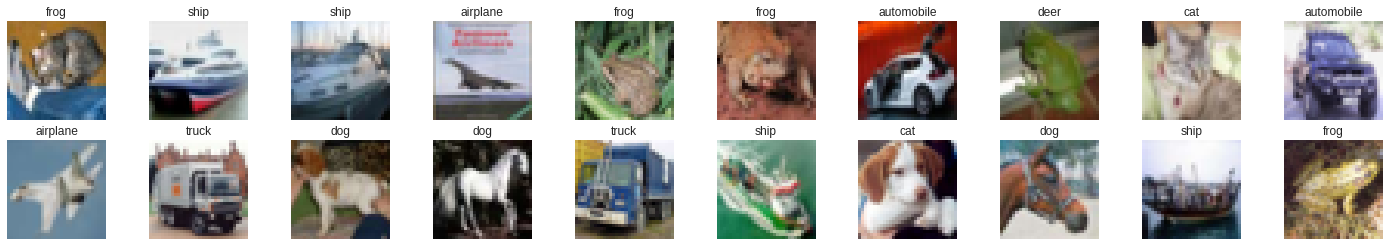

In [31]:
images,labels=next(iter(testloader))
# images=images.numpy()

fig=plt.figure(figsize=(25,4))
for idx in range(20):
    ax=fig.add_subplot(2,20/2,idx+1,xticks=[],yticks=[])
    imshow(images[idx])
    pred=classes[torch.argmax(model.forward(images[idx].unsqueeze(0)))]
    ax.set_title(pred)